## Combine everything

In [1]:
import sys
import subprocess
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'spacy'])
# subprocess.check_call([sys.executable, '-m', 'spacy', 'download', 'en_core_web_sm'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'wordcloud'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'seaborn'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'scikit-learn'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'statsmodels'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'plotly'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nltk'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'nbformat', '--upgrade'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'emoji~=1.6.3'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'text2emotion'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pandarallel'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'textblob'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'pycountry'])
subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'tweet-preprocessor', '--user'])

0

In [2]:
## Read data
import pandas as pd
import re
from collections import Counter
import nltk
from nltk.tokenize import  word_tokenize
from pandarallel import pandarallel
import pickle

import os
import numpy as np

### Actual dataframe

In [3]:
%%time
post_data_full = pd.read_csv('wallstreetbets_submissions_zstextract.csv')
post_data_full.shape

/opt/conda/lib/python3.7/site-packages/IPython/core/magics/execution.py:1335: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


CPU times: user 17.4 s, sys: 8.42 s, total: 25.9 s
Wall time: 25.9 s


(2218243, 14)

In [4]:
import datetime

pandarallel.initialize(nb_workers=16,progress_bar=True)
post_data_full['timestamp'] = post_data_full['created_utc'].parallel_apply(datetime.datetime.fromtimestamp)
post_data_full['timestamp'].min()

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


Timestamp('2012-04-11 16:40:40')

In [5]:
post_data_full['timestamp'].head()

0   2012-04-11 16:40:40
1   2012-04-12 20:37:31
2   2012-04-16 22:29:37
3   2012-04-17 13:41:30
4   2012-04-19 23:21:16
Name: timestamp, dtype: datetime64[ns]

In [6]:
def clean_text(text):
    text = str(text)
    # Remove all text between square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove all text between parentheses
    text = re.sub(r'\(.*?\)', '', text)
    
    # Remove all text between curly braces
    text = re.sub(r'\{.*?\}', '', text)
    
    # Remove all text between angle brackets
    text = re.sub(r'<.*?>', '', text)
    
    # Remove all text between double quotes
    #text = re.sub(r'"(.*?)"', '', text)
    
    # Remove all text between single quotes
    #text = re.sub(r"'(.*?)'", '', text)
    
    # Remove everything between **____**
    text = re.sub(r'\*\*(.*?)\*\*','',text)
    
    # Remove words followed by ^
    text = re.sub(r'(\^\w*)','',text)
    
    # Remove mentions, hashtags, links
    text = re.sub(r'\||:|\-|\n|(@\w+.*?)|(http\w\S+.*?)|(#\w+)','',text)
    
    # Remove all ^Your daily posts
    text = re.sub(r'^Your daily trading discussion.*|^We are now using AutoModerator.*|^Every time a new submission.*|^Trading discussion only.*','',text)
    
    # Remove all newlines, tabs, and extra whitespace
    text = re.sub(r'[\n\t]+', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    
    
    return text

In [7]:
# %%time

# pandarallel.initialize()
post_data_full['clean_text'] = post_data_full['body'].parallel_apply(clean_text)
post_data_full = post_data_full[['id','title','clean_text','author','timestamp','upvotes','num_comments','score']]
post_data_full.groupby(['clean_text'])['author'].count().sort_values(ascending=False).head(5)

clean_text
            1400263
nan          661710
&amp;;         1012
                648
Discuss.        509
Name: author, dtype: int64

In [8]:
## Creating a copy
df = post_data_full.copy()

### Topic LDA

In [9]:
label = pd.read_parquet('label_lda.parquet')

df['topic_label'] = label
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label'],
      dtype='object')

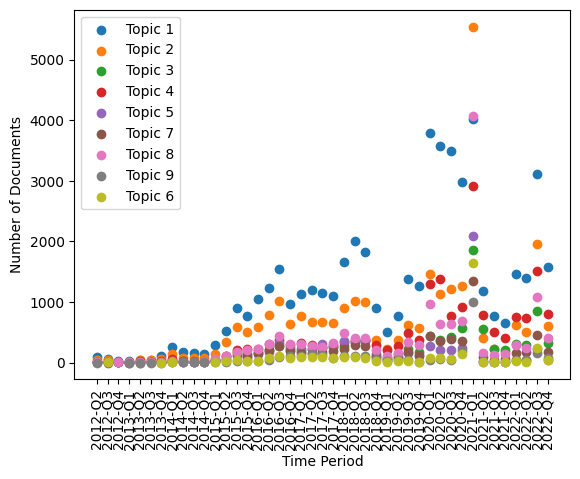

In [10]:
import matplotlib.pyplot as plt

#df['date'] = pd.to_datetime(df['date'])
df['time_period'] = pd.PeriodIndex(df['timestamp'], freq='Q')
count_df = df.groupby(['time_period', 'topic_label']).size().reset_index(name='count')

count_df['time_period'] = count_df['time_period'].dt.strftime('%Y-Q%q')

# Plot the topic timeline
fig, ax = plt.subplots()
for topic in count_df.loc[count_df['topic_label'] != 0, 'topic_label'].unique():
    topic_data = count_df[count_df['topic_label'] == topic]
    ax.scatter(topic_data['time_period'], topic_data['count'], label='Topic {}'.format(topic))
ax.set_xlabel('Time Period')
ax.set_ylabel('Number of Documents')
ax.legend()
plt.xticks(rotation=90)
#ax.set_xticks(quarter_periods)
#ax.set_xticklabels(quarter_periods.strftime('%Y-Q%q'))
plt.show()

Topic 0: Robinhood app, stock trading, and related terminology like "dd" (due diligence), "rh" (Robinhood), and "stonks".

Topic 1: Options trading, including call and put options, and various timeframes (day, week, year).

Topic 2: General discussions on stocks and the market, with terms like "bb" (Blackberry), "wall" (Wall Street), and "street".

Topic 3: Short selling, stock prices, and related terms like "squeeze" (short squeeze), "tendies" (profits), and "nio" (a Chinese electric vehicle company).

Topic 4: Hedge funds, news, and various other topics like the SEC (Securities and Exchange Commission), Donald Trump, and cryptocurrencies.

Topic 5: Buying, holding, and selling stocks, as well as various other related terms like "dip" (a temporary drop in stock prices) and "earnings".

Topic 6: Specific stocks that have gained a lot of attention on WSB, including AMC, Nokia, and Dogecoin, as well as related terms like "moon" and "rocket".

Topic 7: General discussions on stocks and related topics, as well as various other terms like "dogecoin" and "autist".

Topic 8: Discussions related to investing, including the WSB community itself, as well as related terms like "retard" (used humorously) and "gain".

Topic 9: GameStop (GME), a stock that gained a lot of attention on WSB in early 2021, as well as related terms like "next" and "buy".

In [11]:
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period'],
      dtype='object')

### NER Spacy - Large

In [12]:
ner_lg = pd.read_parquet('ner_lg.parquet')

df = pd.concat([df, ner_lg], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period', 'title_ner_lg',
       'text_ner_lg'],
      dtype='object')

In [13]:
df.head()

,id,title,clean_text,author,timestamp,upvotes,num_comments,score,topic_label,time_period,title_ner_lg,text_ner_lg
0,s4jw1,Earnings season is here. Place your bets.,I know that /r/investing is a great place for ...,[deleted],2012-04-11 16:40:40,16,22,13,2,2012Q2,[],[Google]
1,s6r57,"GOOG - beat estimates, price barely rises.",nan,[deleted],2012-04-12 20:37:31,5,0,2,0,2012Q2,[],[]
2,sd5ai,My poorly timed opening position for AAPL earn...,"So I missed out on GOOG, which is probably a g...",[deleted],2012-04-16 22:29:37,14,21,12,1,2012Q2,[],"[OTM, BTO, BTO]"
3,se66f,Anyone betting on VVUS and their potential app...,"I'm normally a long, but I've created a second...",[deleted],2012-04-17 13:41:30,1,0,1,2,2012Q2,"[VVUS, Qnexa]","[Qnexa, FDA]"
4,sinsk,"After HGSI spikes 97%, will share price drop a...",nan,CheeseYogi,2012-04-19 23:21:16,5,0,4,0,2012Q2,[HGSI],[]


### Sentiment

In [14]:
## Sentiment from Pattern Analyzer
sent_patAna = pd.read_parquet('sentiment_title_text.parquet')

df = pd.concat([df, sent_patAna], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period', 'title_ner_lg',
       'text_ner_lg', 'sentiment', 'sentiment_title', 'polarity',
       'subjectivity', 'polarity_title', 'subjectivity_title'],
      dtype='object')

In [15]:
df = df.rename(columns={'sentiment': 'sentiment_text', 'polarity':'polarity_text',
                        'subjectivity':'subjectivity_text'})
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period', 'title_ner_lg',
       'text_ner_lg', 'sentiment_text', 'sentiment_title', 'polarity_text',
       'subjectivity_text', 'polarity_title', 'subjectivity_title'],
      dtype='object')

In [16]:
## Sentiment from Vader
sent_vader_text = pd.read_parquet('sentiment_vader_text.parquet')
sent_vader_title = pd.read_parquet('sentiment_vader_title.parquet')

sent_vader_text = sent_vader_text.rename(columns={'sentiment': 'sentiment_text_vader', 
                                                  'pos':'pos_text',
                                                  'neg':'neg_text',
                                                  'neu':'neu_text'})
sent_vader_title = sent_vader_title.rename(columns={'sentiment': 'sentiment_title_vader', 
                                                  'pos':'pos_title',
                                                  'neg':'neg_title',
                                                  'neu':'neu_title'})

df = pd.concat([df, sent_vader_text, sent_vader_title], axis=1)
df.columns

Index(['id', 'title', 'clean_text', 'author', 'timestamp', 'upvotes',
       'num_comments', 'score', 'topic_label', 'time_period', 'title_ner_lg',
       'text_ner_lg', 'sentiment_text', 'sentiment_title', 'polarity_text',
       'subjectivity_text', 'polarity_title', 'subjectivity_title', 'neg_text',
       'neu_text', 'pos_text', 'compound', 'sentiment_text_vader', 'neg_title',
       'neu_title', 'pos_title', 'compound', 'sentiment_title_vader'],
      dtype='object')

In [17]:
from collections import Counter

flat_list = [item for sublist in df['title_ner_lg'] for item in sublist]

# count values using Counter
Counter(flat_list).most_common(15)

[('GME', 141937),
 ('AMC', 76315),
 ('WSB', 29340),
 ('Robinhood', 25420),
 ('BB', 14812),
 ('Tesla', 12111),
 ('PLTR', 11019),
 ('MOON', 8472),
 ('AMD', 7947),
 ('gme', 7511),
 ('SEC', 6223),
 ('NAKD', 5448),
 ('CNBC', 4683),
 ('TSLA', 4241),
 ('NOK', 4140)]

### Taken the deBERTA algorithm that loads a trained neural network to use on our dataset

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
from transformers import pipeline

2023-03-09 00:07:11.675888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 00:07:15.715113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-03-09 00:07:15.715312: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [19]:
absa_tokenizer = AutoTokenizer.from_pretrained("yangheng/deberta-v3-base-absa-v1.1")
absa_model = AutoModelForSequenceClassification \
  .from_pretrained("yangheng/deberta-v3-base-absa-v1.1")

# Load a traditional Sentiment Analysis model
sentiment_model_path = "nickmuchi/sec-bert-finetuned-finance-classification"
sentiment_model = pipeline("sentiment-analysis", model=sentiment_model_path,
                          tokenizer=sentiment_model_path)

/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


### Trying to determine the sentiment of companies over a period of time. Get the overall bearish/bullish score and the sentiment with the text add to the previous numbers and then average it out

In [20]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')

In [21]:
sp500 = table[0]
sp500 = pd.DataFrame(sp500)
sp500 = sp500[['Symbol', 'Security', 'GICS Sector']]
sp500.head()

,Symbol,Security,GICS Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott,Health Care
3,ABBV,AbbVie,Health Care
4,ACN,Accenture,Information Technology


In [49]:
sp500['occurences'] = 0
sp500['pos_sentiment'] = 0
sp500['neu_sentiment'] = 0
sp500['neg_sentiment'] = 0
sp500.head()

,Symbol,Security,GICS Sector,occurences,pos_sentiment,neu_sentiment,neg_sentiment,average sentiment
0,MMM,3M,Industrials,0,0,0,0,NaN
1,AOS,A. O. Smith,Industrials,0,0,0,0,NaN
2,ABT,Abbott,Health Care,0,0,0,0,NaN
3,ABBV,AbbVie,Health Care,0,0,0,0,NaN
4,ACN,Accenture,Information Technology,0,0,0,0,NaN


In [23]:
pandarallel.initialize(nb_workers=16)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [54]:
df_1 =df[(df['timestamp'] >= '2022-10-01')]

In [55]:
df_1.shape

(54786, 28)

In [34]:
from IPython.display import display,clear_output

In [ ]:
%%time

def apply_ABSA(title,companies):
  # print(title)
  if len(companies) > 1:
    ls = []
    for c in companies:
      inputs = absa_tokenizer(f"[CLS] {title} [SEP] {c} [SEP]", return_tensors="pt")
      outputs = absa_model(**inputs)
      probs = F.softmax(outputs.logits, dim=1)
      probs = probs.detach().numpy()[0]
      for prob, label in zip(probs, ["negative", "neutral", "positive"]):
        if (c in sp500['Symbol'].values):
          sp500.loc[sp500['Symbol'] == c, 'occurences'] = sp500.loc[sp500['Symbol'] == c, 'occurences'] + 1
          sp500.loc[sp500['Symbol'] == c, 'pos_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'pos_sentiment']  + probs[2]
          sp500.loc[sp500['Symbol'] == c, 'neu_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neu_sentiment']  + probs[1]
          sp500.loc[sp500['Symbol'] == c, 'neg_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neg_sentiment']  + probs[0]
        elif (c in sp500['Security'].values):
          sp500.loc[sp500['Security'] == c, 'occurences'] = sp500.loc[sp500['Symbol'] == c, 'occurences'] + 1
          sp500.loc[sp500['Symbol'] == c, 'pos_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'pos_sentiment']  + probs[2]
          sp500.loc[sp500['Symbol'] == c, 'neu_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neu_sentiment']  + probs[1]
          sp500.loc[sp500['Symbol'] == c, 'neg_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neg_sentiment']  + probs[0]
  elif len(companies) == 1:
    c = companies[0]
    inputs = absa_tokenizer(f"[CLS] {title} [SEP] {c} [SEP]", return_tensors="pt")
    outputs = absa_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    probs = probs.detach().numpy()[0]
    if (c in sp500['Symbol'].values):
      sp500.loc[sp500['Symbol'] == c, 'occurences'] = sp500.loc[sp500['Symbol'] == c, 'occurences'] + 1
      sp500.loc[sp500['Symbol'] == c, 'pos_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'pos_sentiment']  + probs[2]
      sp500.loc[sp500['Symbol'] == c, 'neu_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neu_sentiment']  + probs[1]
      sp500.loc[sp500['Symbol'] == c, 'neg_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neg_sentiment']  + probs[0]
    elif (c in sp500['Security'].values):
      sp500.loc[sp500['Security'] == c, 'occurences'] = sp500.loc[sp500['Symbol'] == c, 'occurences'] + 1
      sp500.loc[sp500['Symbol'] == c, 'pos_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'pos_sentiment']  + probs[2]
      sp500.loc[sp500['Symbol'] == c, 'neu_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neu_sentiment']  + probs[1]
      sp500.loc[sp500['Symbol'] == c, 'neg_sentiment'] = sp500.loc[sp500['Symbol'] == c, 'neg_sentiment']  + probs[0]
  sentiment = sentiment_model([title])[0]
  return sentiment

# apply_ABSA("ABT was super bad today, but MMM soared",["ABT","MMM"])
sentiment_df = df.parallel_apply(lambda x: apply_ABSA(x.title,x.title_ner_lg),axis=1)
df_1["Sentiment"] = 0
for i in df.index.values:
  clear_output(wait=True)
  display("index: " + str(i))
  df_1.iloc[i]["Sentiment"] = apply_ABSA(df_1.iloc[i]['title'], df_1.iloc[i]['title_ner_lg'])



'index: 30763'

In [48]:
sp500.head()

,Symbol,Security,GICS Sector,occurences,pos_sentiment,neu_sentiment,neg_sentiment,average sentiment
0,MMM,3M,Industrials,0.0,0.0,0.0,0.0,NaN
1,AOS,A. O. Smith,Industrials,0.0,0.0,0.0,0.0,NaN
2,ABT,Abbott,Health Care,0.0,0.0,0.0,0.0,NaN
3,ABBV,AbbVie,Health Care,0.0,0.0,0.0,0.0,NaN
4,ACN,Accenture,Information Technology,NaN,0.0,0.0,0.0,NaN


In [37]:
sp500['average sentiment'] = (sp500['pos_sentiment']+sp500['neg_sentiment']+sp500['neu_sentiment'])/sp500['occurences']

# Top 10 companies  positive sentiment

In [39]:
sp500.sort_values(by=['average sentiment'], ascending=False).head(10)

,Symbol,Security,GICS Sector,occurences,pos_sentiment,neu_sentiment,neg_sentiment,average sentiment
122,CAG,Conagra Brands,Consumer Staples,6.0,0.018189,5.950344,0.031468,1.0
208,FOX,Fox Corporation (Class B),Communication Services,3.0,0.055946,2.780990,0.163064,1.0
403,ROK,Rockwell Automation,Industrials,1.0,0.008403,0.989684,0.001913,1.0
486,WELL,Welltower,Real Estate,1.0,0.398942,0.589213,0.011845,1.0
70,BK,BNY Mellon,Financials,6.0,0.661882,4.902833,0.435285,1.0
312,MET,MetLife,Financials,13.0,1.138706,11.077150,0.784145,1.0
229,PEAK,Healthpeak,Real Estate,1.0,0.002412,0.995641,0.001947,1.0
495,WYNN,Wynn Resorts,Consumer Discretionary,1.0,0.005289,0.993030,0.001681,1.0
210,FCX,Freeport-McMoRan,Materials,1.0,0.880089,0.099056,0.020855,1.0
371,PCG,PG&E Corporation,Utilities,6.0,5.570994,0.408489,0.020517,1.0


# Top 10 companies negative sentiment

In [40]:
sp500.sort_values(by=['average sentiment'], ascending=True).head(10)

,Symbol,Security,GICS Sector,occurences,pos_sentiment,neu_sentiment,neg_sentiment,average sentiment
338,NEE,NextEra Energy,Utilities,1.0,0.010183,0.978154,0.011663,1.0
155,DPZ,Domino's,Consumer Discretionary,1.0,0.006034,0.990332,0.003633,1.0
93,CBOE,Cboe Global Markets,Financials,6.0,0.040837,5.944692,0.014471,1.0
305,MTCH,Match Group,Communication Services,3.0,0.138877,2.848612,0.012511,1.0
119,CL,Colgate-Palmolive,Consumer Staples,1.0,0.003690,0.267389,0.728921,1.0
34,AWK,American Water Works,Utilities,3.0,0.021215,2.538912,0.439873,1.0
298,MPC,Marathon Petroleum,Energy,3.0,0.154481,1.984616,0.860903,1.0
266,JNJ,Johnson & Johnson,Health Care,15.0,2.478903,12.316125,0.204971,1.0
60,BBWI,"Bath & Body Works, Inc.",Consumer Discretionary,1.0,0.003112,0.993728,0.003160,1.0
461,UNP,Union Pacific Corporation,Industrials,3.0,0.948897,2.033710,0.017392,1.0


# For Posts

In [41]:
df_1.head(10)

,id,title,clean_text,author,timestamp,upvotes,num_comments,score,topic_label,time_period,...,neg_text,neu_text,pos_text,compound,sentiment_text_vader,neg_title,neu_title,pos_title,compound,sentiment_title_vader
2143847,x2sqm7,Bed Bath executives thinking about what to do ...,,[deleted],2022-09-01 00:02:06,0,8,11,0,2022Q3,...,0.0,0.000,0.000,0.0000,Neutral,0.000,1.000,0.000,0.0000,Neutral
2143848,x2sqn5,SLNO 10x soon I've been a self-administered bu...,,Proper_Sport4567,2022-09-01 00:02:07,0,2,1,0,2022Q3,...,0.0,0.000,0.000,0.0000,Neutral,0.000,0.884,0.116,0.6590,Positive
2143849,x2sr76,NVAX NovaVax the First vaccine Meme stock,My fellow Protein lovers. For too Long Moderna...,Hope77797,2022-09-01 00:02:50,0,21,0,7,2022Q3,...,0.0,0.865,0.135,0.8356,Positive,0.000,1.000,0.000,0.0000,Neutral
2143850,x2srdv,when the only sub you been scrolling through i...,,[deleted],2022-09-01 00:03:04,0,2,1,0,2022Q3,...,0.0,0.000,0.000,0.0000,Neutral,0.084,0.916,0.000,-0.0953,Negative
2143851,x2ssan,"Highly esteemed fucktards, let's take a moment...",,[deleted],2022-09-01 00:04:16,0,0,1,0,2022Q3,...,0.0,0.000,0.000,0.0000,Neutral,0.000,0.715,0.285,0.4927,Positive
2143852,x2ssoq,SLNO 10x soon,nan,Proper_Sport4567,2022-09-01 00:04:48,0,2,1,0,2022Q3,...,0.0,1.000,0.000,0.0000,Neutral,0.000,1.000,0.000,0.0000,Neutral
2143853,x2sswk,Starting a discord soon… may start charging su...,nan,richiezoidz,2022-09-01 00:05:04,0,46,225,0,2022Q3,...,0.0,1.000,0.000,0.0000,Neutral,0.174,0.645,0.181,0.0258,Positive
2143854,x2sths,good invest 10x,nan,Proper_Sport4567,2022-09-01 00:05:48,0,3,0,0,2022Q3,...,0.0,1.000,0.000,0.0000,Neutral,0.000,0.408,0.592,0.4404,Positive
2143855,x2stp2,The average GME holders vehicle.,nan,Cmanzoni5,2022-09-01 00:06:04,0,51,5,0,2022Q3,...,0.0,1.000,0.000,0.0000,Neutral,0.000,1.000,0.000,0.0000,Neutral
2143856,x2su2k,It's alright guys BBBY is gonna hit $45 until ...,nan,Juffin,2022-09-01 00:06:29,0,36,58,0,2022Q3,...,0.0,1.000,0.000,0.0000,Neutral,0.000,0.846,0.154,0.4588,Positive
